# Logistic Regression

1. [The Tasks](#tt) <br>
2. [Loading our Data and Libraries](#ld) <br>
3. [Logistic Regression with Cross Validation](#lr) <br>
4. [Plotting Imgages and Probabilties](#pi) <br>
5. [Making Predictions](#mp)


***

## The Tasks
<a id="tt" > 

Using the high-level OverFeat features

- Create a logistic regression estimator with an optional PCA preprocessing step.
- Tune the regularization strength and the number of components using grid search with cross-validation. Try with and without PCA.
- Collect the results in a DataFrame, print the best parameters and evaluate the test accuracy.


Using your tuned estimator

- Pick ten images from the test set and print the class probabilities.
- Try with different regularization strengths. Write your observations.

***

## Loading/Preparing our Data and Libraries
<a id="ld" > 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
sns.set()
%matplotlib inline

In [2]:
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())
print('Our data countains {}'.format(cifar4.keys()))

dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [3]:
X_of = cifar4['overfeat']
y = cifar4['labels']
X_pix = cifar4['pixels']
names = cifar4['names']

# Splitting our data into a train- and test set 
X_tr, X_te, y_tr, y_te, pix_tr, pix_te, labels_tr, labels_te = train_test_split(X_of, y, 
                                                                                X_pix, y, 
                                                                                test_size=1000, 
                                                                                random_state=0)

print('Train shape:', X_tr.shape)
print('Test shape:', X_te.shape)
print('Pixes shape:', pix_tr.shape)
print('Labels shape:', labels_tr.shape)

Train shape: (4000, 4096)
Test shape: (1000, 4096)
Pixes shape: (4000, 3072)
Labels shape: (4000,)


In [12]:
with np.load('cifar4-test.npz',allow_pickle=False) as npz_file:
    pred_data = dict(npz_file.items())
print (pred_data.keys())

X_pred = pred_data['overfeat']

dict_keys(['pixels', 'overfeat', 'allow_pickle'])


***

## Logistic Regression with Cross Validation
<a id="lr" > 

In [4]:
pca = PCA()
LogReg = LogisticRegression()

pipe = Pipeline([('pca', pca),
                 ('LogReg', LogReg)])

In [5]:
Cs = [0.001, 0.01, 0.1, 1, 10]
n_components = np.arange(100, 800, 100) 
# We try with and without PCA
n_components = np.append(n_components, X_of.shape[1])

grid_cv = GridSearchCV(pipe,
                       [{'LogReg__C': Cs, 
                        'pca__n_components': n_components}],
                         cv=5, 
                         n_jobs=-1)

grid_cv.fit(X_tr, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('LogReg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'LogReg__C': [0.001, 0.01, 0.1, 1, 10], 'pca__n_components': array([ 100,  200,  300,  400,  500,  600,  700, 4096])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [6]:
cv_df = pd.DataFrame(grid_cv.cv_results_)[['param_LogReg__C', 
                                           'param_pca__n_components',
                                           'mean_test_score', 
                                           'std_test_score',
                                           'mean_train_score',
                                           'std_train_score']]
cv_df.head()

,param_LogReg__C,param_pca__n_components,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.001,100,0.82075,0.009175,0.841940,0.003872
1,0.001,200,0.83225,0.009088,0.859563,0.002869
2,0.001,300,0.83475,0.006753,0.868625,0.000917
3,0.001,400,0.83550,0.004437,0.874812,0.002243
4,0.001,500,0.83650,0.006754,0.877813,0.001867


In [7]:
best = cv_df['mean_test_score'].idxmax()

print('Our best accuracy was {:.3f} and we achieved this with a C value of {} and {} components'
      .format(cv_df.loc[best, 'mean_test_score'], 
              cv_df.loc[best, 'param_LogReg__C'],
              cv_df.loc[best, 'param_pca__n_components']))

Our best accuracy was 0.851 and we achieved this with a C value of 0.01 and 4096 components


In [11]:
grid_cv.score(X_te, y_te)

0.84

***

## Plotting Imgages and Probabilties
<a id="pi" > 

In [8]:
# We take ten random pictures from the test set and compute their class-probabilities
random_10 = random.sample(range(0, len(X_te)), 10)
probability_best = grid_cv.best_estimator_.predict_proba(X_te[random_10])
df = pd.DataFrame(probability_best, columns=['truck','car','airplane','ship']).round(2)

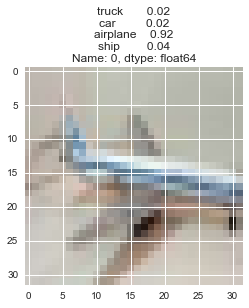

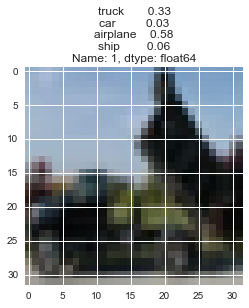

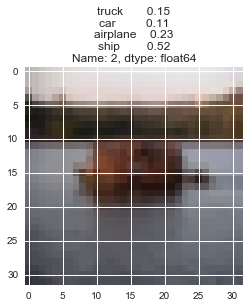

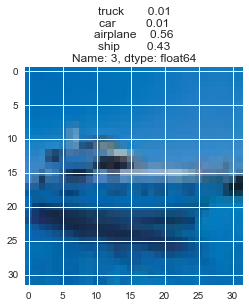

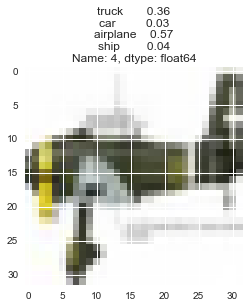

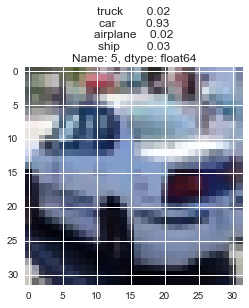

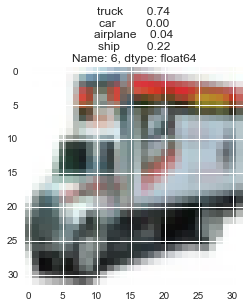

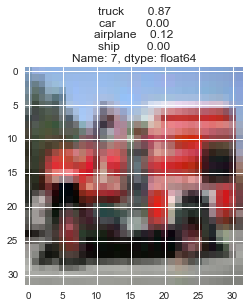

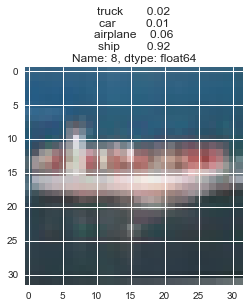

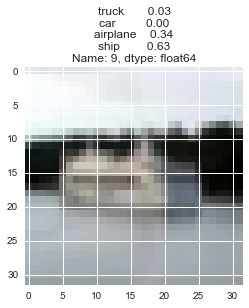

In [9]:
# Plotting the pictures and their class-probabilities
ten_pix  = pix_te[random_10]
for i in range(len(ten_pix)):
    flat_img = ten_pix [i,:]
    img = flat_img.reshape(32, 32, 3)
    plt.imshow(img)
    plt.title(df.iloc[i])
    plt.show()
    
plt.show()

In [10]:
x_prob = []
Cs = [0.001, 0.01, 0.1, 1, 10]

# The effect of regularization on probabilities
for i, c in enumerate(Cs):
    pca = PCA(n_components= 200)
    LogReg = LogisticRegression(C= c)
    pipe = Pipeline([('pca', pca),
                   ('LogReg', LogReg)])
    pipe.fit(X_tr, y_tr)
    probabilities = pipe.predict_proba(X_te[random_10])
    x_prob.append(probabilities)
    dfi = pd.DataFrame(x_prob[i], columns=['truck','car','airplane','ship']).round(2)
    dfi['std'] = dfi.std(axis=1)
    print('C = {}'.format(c))
    print(dfi)

C = 0.001
   truck   car  airplane  ship       std
0   0.08  0.10      0.72  0.10  0.313475
1   0.29  0.05      0.52  0.14  0.205426
2   0.15  0.12      0.16  0.57  0.214009
3   0.04  0.03      0.49  0.44  0.249132
4   0.35  0.08      0.45  0.13  0.176328
5   0.13  0.64      0.05  0.18  0.265456
6   0.65  0.02      0.19  0.15  0.274757
7   0.72  0.02      0.25  0.01  0.332365
8   0.14  0.02      0.09  0.74  0.332002
9   0.14  0.03      0.31  0.52  0.213698
C = 0.01
   truck   car  airplane  ship       std
0   0.03  0.02      0.86  0.09  0.407840
1   0.27  0.01      0.61  0.10  0.264622
2   0.10  0.10      0.10  0.70  0.300000
3   0.01  0.01      0.60  0.39  0.292845
4   0.34  0.04      0.58  0.04  0.261534
5   0.07  0.82      0.01  0.10  0.381838
6   0.86  0.00      0.06  0.07  0.409502
7   0.88  0.00      0.12  0.00  0.423792
8   0.04  0.00      0.03  0.92  0.448655
9   0.04  0.01      0.17  0.77  0.355188
C = 0.1
   truck   car  airplane  ship       std
0   0.01  0.00      0.94  0.05

it seems like as our alpha increases, the respective probability increases too. High probabilities get higher and lower ones get lower. We can see this by looking at the horizontal standard deviation. This might be a sign of overfitting.

***

## Making Predictions
<a id="mp" > 

We use Logistic Regression with our discovered hyperparameters for our predictions as it seems to be the best estimator for the kind of task at hand.

In [13]:
results = grid_cv.predict(X_pred)
np.save('test-predictions.npy', results)
results 

array([2, 3, 2, 3, 2, 3, 3, 3, 0, 2, 3, 0, 3, 1, 0, 2, 3, 3, 2, 0, 1, 0,
       1, 2, 3, 1, 2, 0, 2, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 2, 3, 0, 2,
       2, 2, 1, 1, 1, 3, 3, 1, 0, 1, 2, 3, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1,
       3, 2, 0, 1, 3, 3, 3, 2, 3, 3, 0, 3, 3, 1, 3, 0, 2, 3, 1, 0, 2, 3,
       3, 2, 2, 1, 1, 0, 1, 2, 0, 1, 3, 1, 3, 2, 0, 3, 3, 3, 1, 2, 1, 3,
       0, 1, 1, 0, 2, 1, 2, 1, 1, 2, 0, 1, 2, 0, 2, 2, 3, 1, 1, 1, 0, 1,
       0, 3, 3, 2, 2, 1, 1, 1, 0, 2, 3, 2, 1, 2, 3, 0, 1, 1, 1, 2, 0, 2,
       3, 1, 3, 0, 3, 2, 3, 2, 0, 1, 2, 1, 0, 3, 3, 3, 0, 3, 0, 3, 0, 2,
       1, 2, 2, 0, 3, 2, 1, 0, 3, 2, 3, 3, 1, 0, 3, 0, 3, 0, 3, 3, 1, 2,
       3, 2, 3, 0, 3, 0, 1, 2, 1, 1, 2, 2, 1, 2, 1, 0, 3, 1, 0, 0, 0, 1,
       1, 3, 3, 2, 1, 0, 3, 3, 0, 1, 2, 0, 2, 3, 1, 3, 2, 2, 2, 3, 1, 2,
       1, 3, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 3, 3, 1, 3, 3,
       1, 1, 1, 3, 3, 0, 1, 3, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2, 1, 3, 3, 3,
       2, 3, 3, 1, 3, 1, 2, 1, 2, 2, 3, 2, 0, 1, 1,